Figure 3  

Location responses bubble plot

In [1]:
# Imports
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse, Rectangle

# data handling
import pandas as pd
import numpy as np
import scipy

# data analysis
from scipy.stats import wilcoxon


In [2]:
dataDir = os.getcwd()
plotDir = '../plots'
# print(plotDir)
allDataDir = os.path.join(dataDir, 'mat', 'allData.mat')

# Load the .mat file
mat_data = scipy.io.loadmat(allDataDir)

# Access the 'allData' structure
all_data = mat_data['allData']

C:\Users\ailen\AppData\Local\Temp\ipykernel_34176\20757738.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


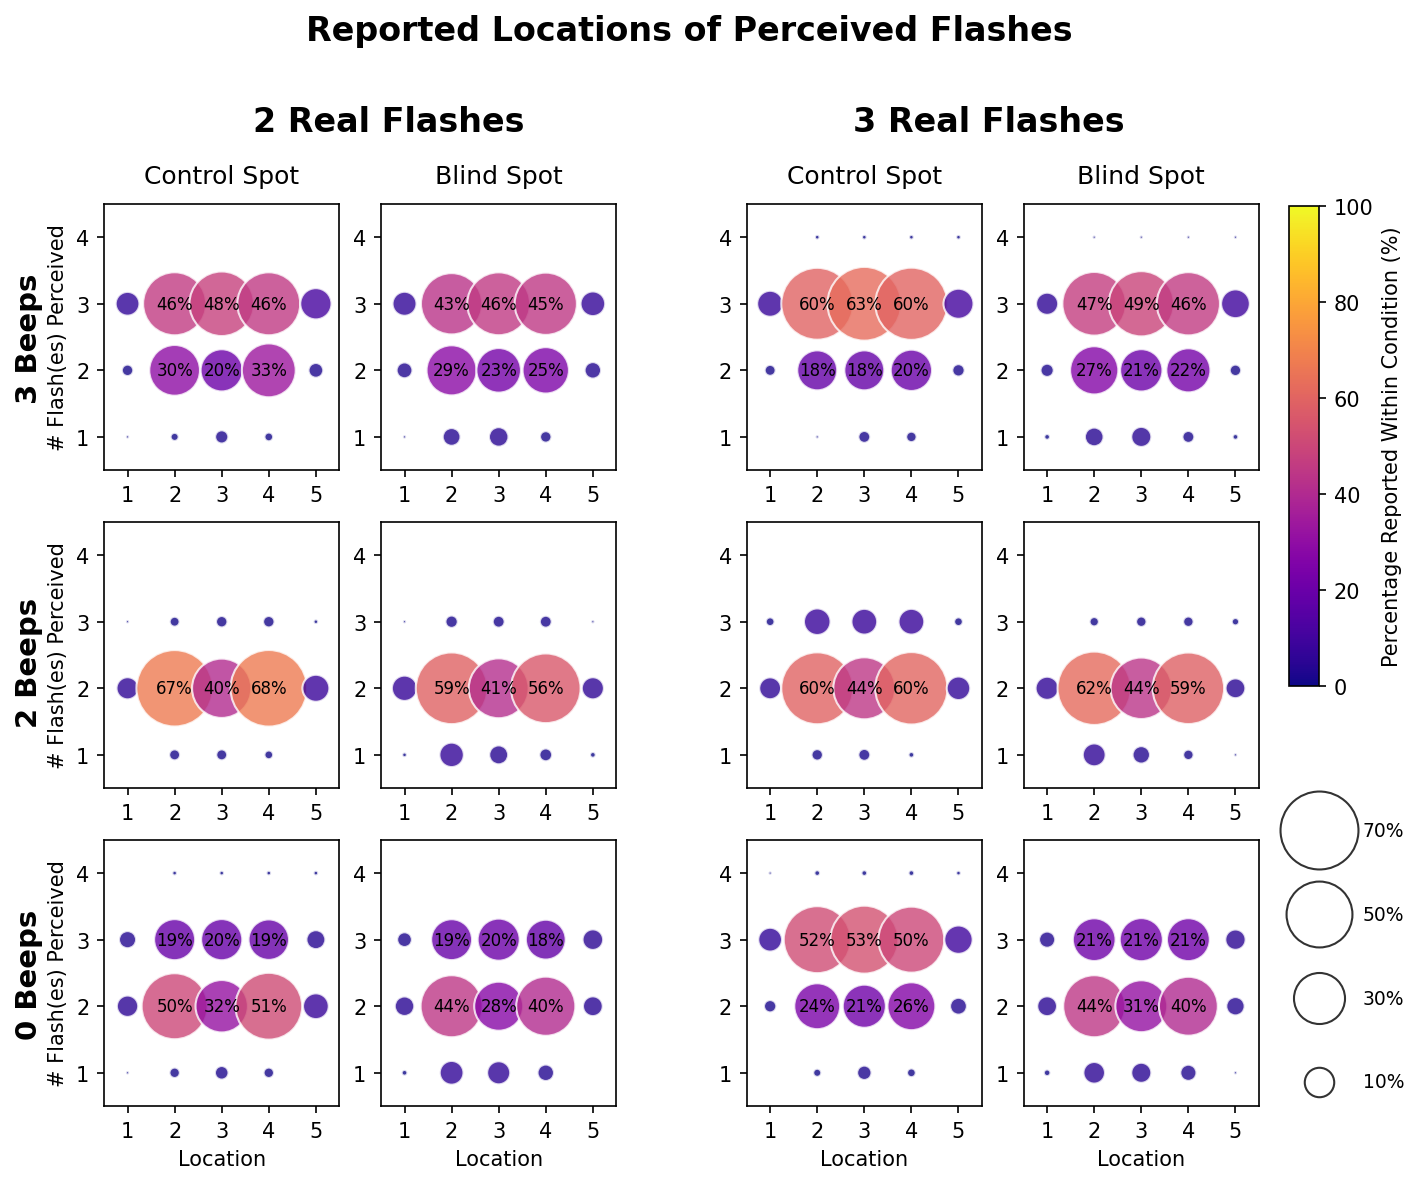

In [3]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

csv_files = [f for f in os.listdir('csv') if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join('csv', f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Only keep flash trials
flash_df = df[df['response_type'] == 1].copy()

# 12 subplots
# 2 Real Flashes - 3 Real Flashes
# Contrl-BS, Control-BS
# B3 - B2 - B0 (top -> bottom)

n_flash_conditions = [2, 3]
n_beep_conditions = [3, 2, 0]
blindspot_conditions = [0, 1]

fig = plt.figure(figsize=(10, 8), dpi=150)
fig.suptitle('Reported Locations of Perceived Flashes', y=1.06, fontsize=16, fontweight='bold')
norm = Normalize(vmin=0, vmax=100)
cmap = plt.get_cmap('plasma')

gs = plt.GridSpec(3, 5, figure=fig, width_ratios=[1, 1, 0.2, 1, 1])
axs = []
col_mapping = {0:0, 1:1, 2:3, 3:4}

for j, n_beep in enumerate(n_beep_conditions):  # Rows (0-2) by beep count
    for i, n_flash in enumerate(n_flash_conditions):  # Flash count groups (2,3)
        for k, blindspot in enumerate(blindspot_conditions):  # Control vs blind (0,1)
            new_col = col_mapping[i*2 + k]
            ax = fig.add_subplot(gs[j, new_col])
            axs.append(ax)           
            
            # Filter data for current condition
            condition_trials = flash_df[
                (flash_df['n_flash'] == n_flash) & 
                (flash_df['n_beep'] == n_beep) & 
                (flash_df['blindspot'] == blindspot)
            ]
            
            if len(condition_trials) == 0:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
                continue
            
            # Calculate percentages
            results = []
            for flash_percept in range(1, 5):
                subset = condition_trials[condition_trials['response'] == flash_percept]
                if len(subset) > 0:
                    for loc in range(1, 6):
                        loc_col = f'loc_{loc}'
                        perc = subset[loc_col].sum() / len(condition_trials) * 100
                        results.append({
                            'response': flash_percept,
                            'location': loc,
                            'percentage': perc,
                            'size': perc*20,
                            'total_trials': len(subset)
                        })
            
            results_df = pd.DataFrame(results)
            
            # Plot bubbles with size proportional to trial count
            scatter = ax.scatter(
                x='location',
                y='response',
                s='size',
                c='percentage',
                cmap=cmap,
                norm=norm,
                data=results_df,
                alpha=0.8,
                edgecolors='w'
            )
            
            # Add percentage labels 
            for _, row in results_df.iterrows():
                if row['percentage'] > 15:  # Only show if percentage > 15%
                    ax.text(
                        row['location'], row['response'],
                        f"{row['percentage']:.0f}%",
                        ha='center', va='center',
                        fontsize=8,
                        color='black' #if row['percentage'] > 50 else 'white'
                    )
    
            condition_name = 'Control Spot' if blindspot == 0 else 'Blind Spot'
            ax.set_title(condition_name, pad=10) if n_beep == 3 else ax.set_title('')
            ax.set_xlabel('Location') if n_beep == 0 else ax.set_xlabel('')
            ax.set_ylabel('# Flash(es) Perceived') if n_flash == 2 and blindspot == 0 else ax.set_ylabel('')
            ax.set_yticks([1, 2, 3, 4])
            ax.set_xticks([1, 2, 3, 4, 5])
            ax.set_ylim(0.5, 4.5)
            ax.set_xlim(0.5, 5.5)
    
# Add colorbar
cbar_ax = fig.add_axes([0.9, 0.5, 0.02, 0.4]) #left, bottom, width, height
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='Percentage Reported Within Condition (%)')

# Bubble size legend
size_legend_ax = fig.add_axes([0.88, 0.1, 0.08, 0.35])  # Positioned below colorbar
size_legend_ax.axis('off')  # Hide axes
size_legend_ax.set_ylim(0, 1)  # Set y limits for the legend

size_percent_pairs = [
    (1400, "70%"),
    (1000, "50%"),
    (600, "30%"),
    (200, "10%"),
]

# Vertical positions for the bubbles (from top to bottom)
y_positions = np.linspace(0.8, 0.2, len(size_percent_pairs))

# Plot size legend
for (size, perc), y in zip(size_percent_pairs, y_positions):
    size_legend_ax.scatter(
        [0], [y], 
        s=size, 
        color='w',
        alpha=0.8, 
        edgecolors='k',
        linewidth=1
    )
    size_legend_ax.text(
        0.04, y, perc, 
        va='center', 
        ha='left', 
        fontsize=9,
        fontfamily='sans-serif'
    )

fig.text(0.3, .97, '2 Real Flashes', ha='center', va='center', fontsize=16, fontweight='bold')
fig.text(0.7, .97, '3 Real Flashes', ha='center', va='center', fontsize=16, fontweight='bold')

beep_labels = ['3 Beeps', '2 Beeps', '0 Beeps']
for label, label_y in zip(beep_labels, [.79, .52, .26]):
    fig.text(0.06, label_y, label, ha='center', va='center', fontsize=14, fontweight='bold', rotation=90)

plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.88, bottom=0.15)

plt.savefig(os.path.join(plotDir, 'fig_3_locations.png'), dpi=150)
plt.show()